# MSA 2025 Phase 2 - Part 1

In [182]:
import warnings
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
%matplotlib inline
warnings.filterwarnings('ignore')

## 1. Find all variables and understand them

### 1.1 datasets overview

In [183]:
# load three datasets in
W_store_features = pd.read_csv(
    r"D:\MSA_PROJECT\phase2_project\data-science\1. Analysis and Preprocessing\datasets\W store sales\features.csv"
    )
W_store_sales = pd.read_csv(
    r"D:\MSA_PROJECT\phase2_project\data-science\1. Analysis and Preprocessing\datasets\W store sales\sales.csv"
    )
W_store_stores = pd.read_csv(
    r"D:\MSA_PROJECT\phase2_project\data-science\1. Analysis and Preprocessing\datasets\W store sales\stores.csv"
    )

print(f'W_store_features has {W_store_features.shape[0]} rows')
print(f'W_store_sales has {W_store_sales.shape[0]} rows')
print(f'W_store_sales has {W_store_stores.shape[0]} rows')

W_store_features has 8190 rows
W_store_sales has 421570 rows
W_store_sales has 45 rows


In [184]:
# merge all three into one df 
# (one to many mapping,fault Cartesian product no need to concern)
df = pd.merge(W_store_features,W_store_sales,on = ["Store","Date"],how="inner")
df = pd.merge(df,W_store_stores, on = "Store", how = "inner")

df = df.drop(columns=["IsHoliday_y"]).rename(columns={"IsHoliday_x": "IsHoliday"})

print(f'df has {df.shape[0]} rows')
print(f'df has {df.shape[1]} features')

df has 421570 rows
df has 16 features


<p>Combined three separate datasets into one by joining keys. The combination of date and store should be used as the key to join between `sales.csv` and `features.csv` other than use date singly. We can see the combined dataset has 421570 rows and 16 features.</p>

In [185]:
# first 10 instances
df.head(10)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1,24924.50,A,151315
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2,50605.27,A,151315
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,3,13740.12,A,151315
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,4,39954.04,A,151315
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5,32229.38,A,151315
5,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,6,5749.03,A,151315
6,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,7,21084.08,A,151315
7,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,8,40129.01,A,151315
8,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,9,16930.99,A,151315
9,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,10,30721.50,A,151315


In [186]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.groupby('Date', as_index=False).agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'MarkDown1': 'mean',
    'MarkDown2': 'mean',
    'MarkDown3': 'mean',
    'MarkDown4': 'mean',
    'MarkDown5': 'mean',
    'IsHoliday': 'any'  
})
df.head(10)

,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday
0,2010-02-05,49750740.50,33.277942,2.717869,167.398405,8.576731,NaN,NaN,NaN,NaN,NaN,False
1,2010-02-12,48336677.63,33.361810,2.696102,167.384138,8.567309,NaN,NaN,NaN,NaN,NaN,True
2,2010-02-19,48276993.78,37.038310,2.673666,167.338966,8.576351,NaN,NaN,NaN,NaN,NaN,False
3,2010-02-26,43968571.13,38.629563,2.685642,167.691019,8.561375,NaN,NaN,NaN,NaN,NaN,False
4,2010-03-05,46871470.30,42.373998,2.731816,167.727351,8.572689,NaN,NaN,NaN,NaN,NaN,False
5,2010-03-12,45925396.51,46.967143,2.774452,167.504162,8.580858,NaN,NaN,NaN,NaN,NaN,False
6,2010-03-19,44988974.64,49.481019,2.816063,167.478101,8.571996,NaN,NaN,NaN,NaN,NaN,False
7,2010-03-26,44133961.05,47.979325,2.823610,167.510338,8.575041,NaN,NaN,NaN,NaN,NaN,False
8,2010-04-02,50423831.26,52.587887,2.825453,167.377836,8.441092,NaN,NaN,NaN,NaN,NaN,False
9,2010-04-09,47365290.44,58.098526,2.852423,167.265977,8.442531,NaN,NaN,NaN,NaN,NaN,False


Our mission is to predict the sales week by week for at least 4 weeks. Since the metric granularity isn't tied to store or dept, we can combine these two features and analyze the data by week only. Also the size and the type of the store are meaningless after aggregated since I remove them from the dataset.

### 1.2 key statistical measures

In [187]:
df.describe(include='all')

,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday
count,143,1.430000e+02,143.000000,143.000000,143.000000,143.000000,51.000000,48.000000,51.000000,51.000000,51.000000,143
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133
mean,2011-06-17 00:00:00,4.711342e+07,60.141472,3.359418,171.186095,7.962458,7248.558856,2633.081441,1384.435813,3288.831690,4625.532989,NaN
min,2010-02-05 00:00:00,3.959985e+07,29.807584,2.673666,167.065968,6.942141,587.152547,23.115709,0.270000,70.420365,1891.406624,NaN
25%,2010-10-11 12:00:00,4.488059e+07,47.176068,2.884495,168.004929,7.484837,4296.635367,92.417075,18.062954,843.443397,3172.167390,NaN
50%,2011-06-17 00:00:00,4.624390e+07,60.530277,3.490246,171.018134,8.096383,5460.935432,211.123149,56.536565,1924.698826,3861.637002,NaN
75%,2012-02-20 12:00:00,4.779202e+07,74.208439,3.729174,174.316614,8.388105,8350.226685,1670.038463,102.946504,3236.925171,5832.907671,NaN
max,2012-10-26 00:00:00,8.093142e+07,81.886773,3.997432,176.295499,8.580858,38318.227017,41809.250023,61817.075106,31502.484083,18683.272846,NaN


### 1.3 visualization for numerical data

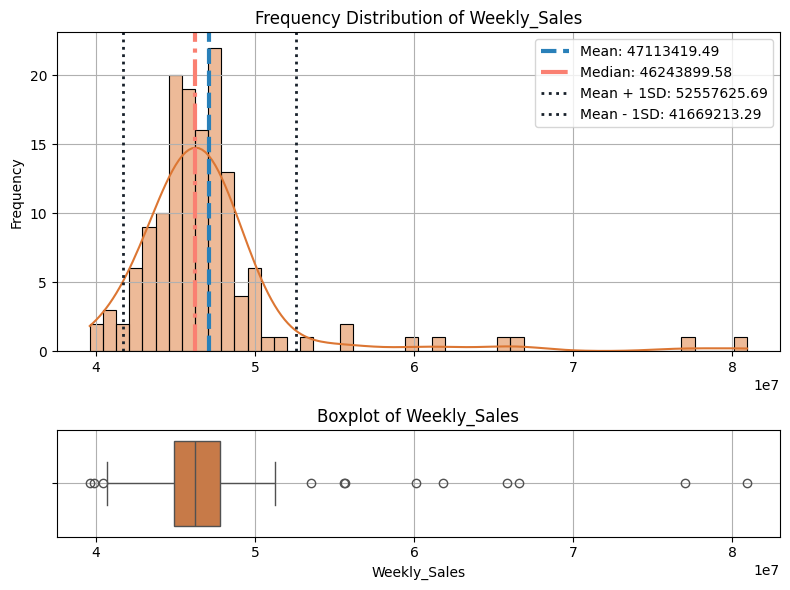

In [188]:
def show_distribution_with_stats(column):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})

    data = column.dropna()
    mean = data.mean()
    median = data.median()
    std = data.std()

    # hist
    sns.histplot(data, ax=axs[0], bins=50, kde=True,color='#dc7633')
    axs[0].axvline(mean, color='#2980b9', linestyle='--', linewidth=3, label=f"Mean: {mean:.2f}")
    axs[0].axvline(median, color='#FA8072', linestyle='-.', linewidth=3, label=f"Median: {median:.2f}")
    axs[0].axvline(mean + std, color='#17202a', linestyle=':', linewidth=2, label=f"Mean + 1SD: {mean+std:.2f}")
    axs[0].axvline(mean - std, color='#17202a', linestyle=':', linewidth=2, label=f"Mean - 1SD: {mean-std:.2f}")
    axs[0].set_title(f"Frequency Distribution of {column.name}")
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Frequency")
    axs[0].legend()
    axs[0].grid(True)

    # boxplot
    sns.boxplot(x=data, ax=axs[1], color='#dc7633')
    axs[1].set_title(f"Boxplot of {column.name}")
    axs[1].set_xlabel(column.name)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


show_distribution_with_stats(df["Weekly_Sales"])

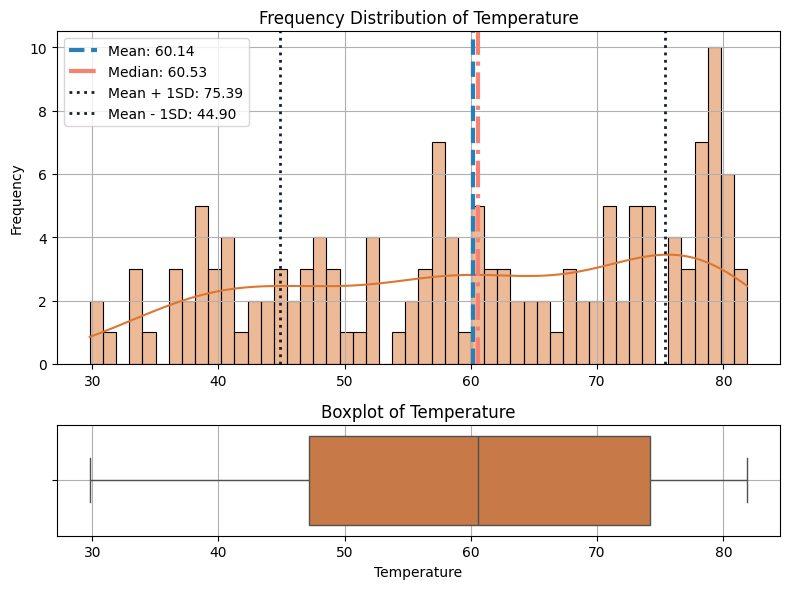

In [189]:

show_distribution_with_stats(df["Temperature"])


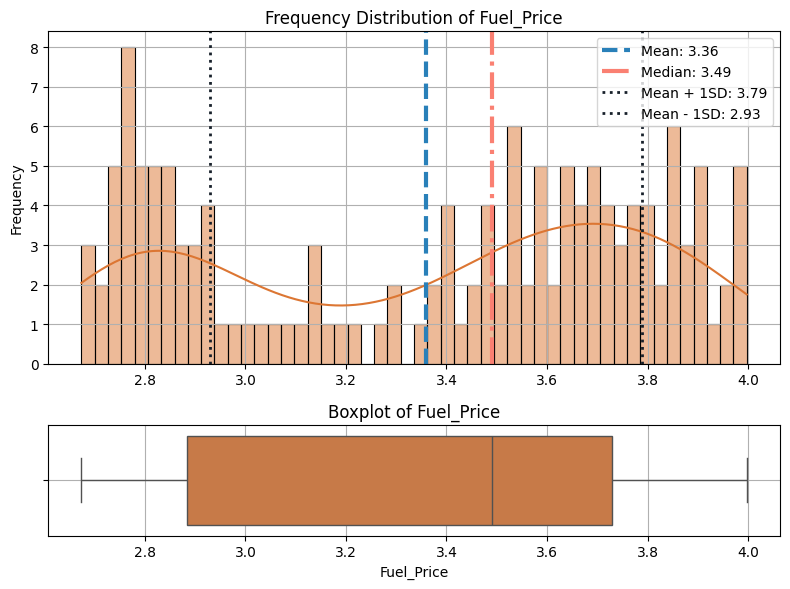

In [190]:
show_distribution_with_stats(df["Fuel_Price"])

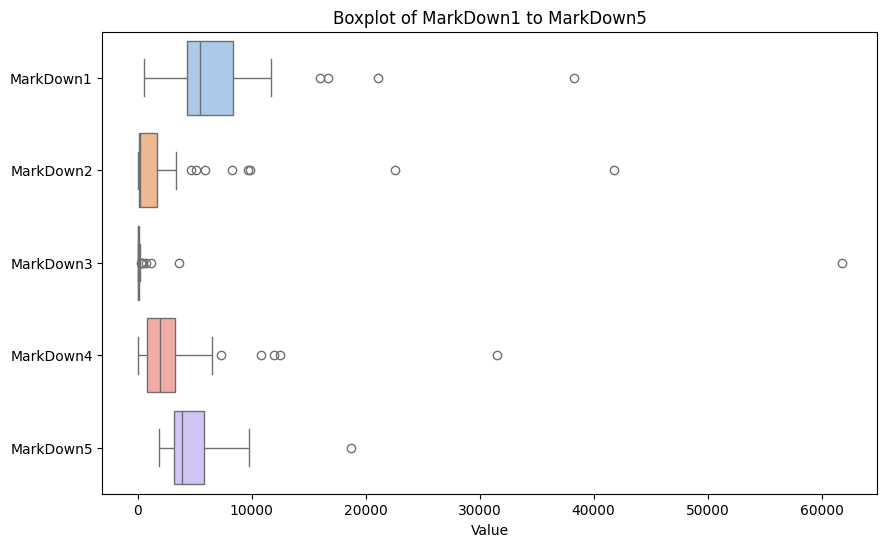

In [191]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[[f"MarkDown{i}" for i in range(1, 6)]], orient="h", palette="pastel")
plt.title("Boxplot of MarkDown1 to MarkDown5")
plt.xlabel("Value")
plt.show()

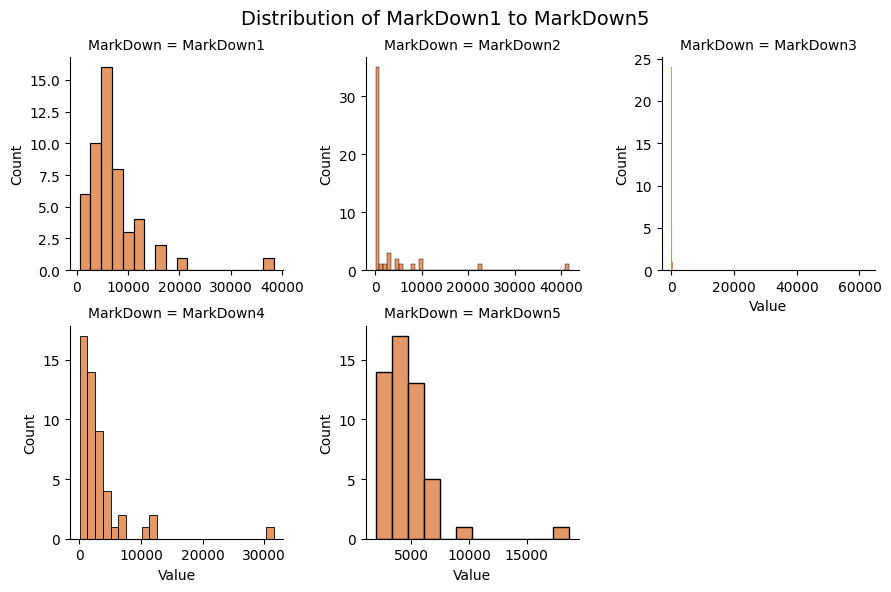

In [192]:
melted = df[[f"MarkDown{i}" for i in range(1, 6)]].melt(var_name="MarkDown", value_name="Value")

g = sns.FacetGrid(melted, col="MarkDown", col_wrap=3, height=3, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="Value", color="#dc7633")  # 设置颜色

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of MarkDown1 to MarkDown5", fontsize=14)
plt.show()

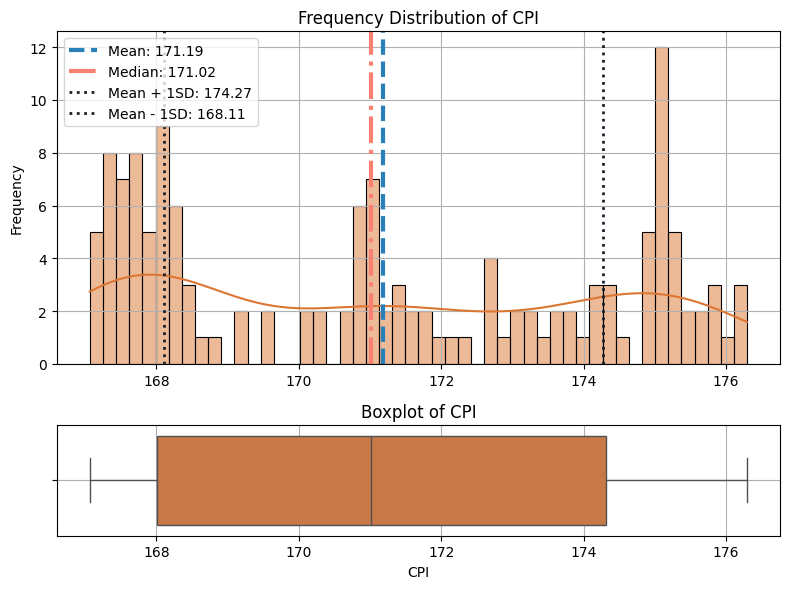

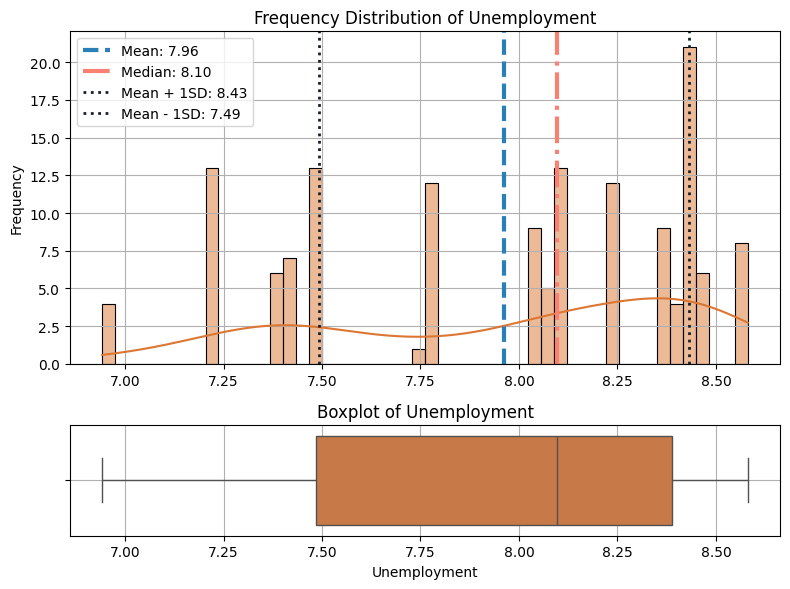

In [193]:
show_distribution_with_stats(df["CPI"])
show_distribution_with_stats(df["Unemployment"])

### 1.4 convert non-numerical to numerical

In [194]:
df.dtypes

Date            datetime64[ns]
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
IsHoliday                 bool
dtype: object

Before I am going to covert non-numerical feature to numerical by one-hot encoding. I am going to break down the dates into **Year**, **Month**, **Day**. Because a datetime object is not numerical but our mission is still depend on these dates. 

In [195]:
# date break down
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df.head(5)

,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,Year,Month,Day
0,2010-02-05,49750740.50,33.277942,2.717869,167.398405,8.576731,NaN,NaN,NaN,NaN,NaN,False,2010,2,5
1,2010-02-12,48336677.63,33.361810,2.696102,167.384138,8.567309,NaN,NaN,NaN,NaN,NaN,True,2010,2,12
2,2010-02-19,48276993.78,37.038310,2.673666,167.338966,8.576351,NaN,NaN,NaN,NaN,NaN,False,2010,2,19
3,2010-02-26,43968571.13,38.629563,2.685642,167.691019,8.561375,NaN,NaN,NaN,NaN,NaN,False,2010,2,26
4,2010-03-05,46871470.30,42.373998,2.731816,167.727351,8.572689,NaN,NaN,NaN,NaN,NaN,False,2010,3,5


The dataset only contains one non-numerical feature which it is **IsHoliday**. I need to change it into a numerical format. Since it is a boolean data type, we can just easy to convet True to 1 and False to 0. 

In [196]:
# get True/False convert as 1/0
df['IsHoliday'] = df['IsHoliday'].astype(int)
df.head(2)

,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,Year,Month,Day
0,2010-02-05,49750740.50,33.277942,2.717869,167.398405,8.576731,NaN,NaN,NaN,NaN,NaN,0,2010,2,5
1,2010-02-12,48336677.63,33.361810,2.696102,167.384138,8.567309,NaN,NaN,NaN,NaN,NaN,1,2010,2,12


The one-hot encoding method hasn't been used here explicitly because after the data cleanning process the dataset has only left 1 feature that is boolean.

The original date will be deleted later on, as it will be used to visualize purpose only.

## 2. Visualise data for non-numerical data

In [197]:
# create a fucntion can be reused
def aggregate_and_plot(df, date_col, value_col, freq="W", title=None):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col]) 

    df_agg = df.resample(freq, on=date_col)[value_col].sum().reset_index()

    # plot a time series plot
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_agg, x=date_col, y=value_col,color = "#dc7633")
    plt.title(title or f"{value_col} Aggregated by {freq}")
    plt.xlabel("Date")
    plt.ylabel(f"Total {value_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



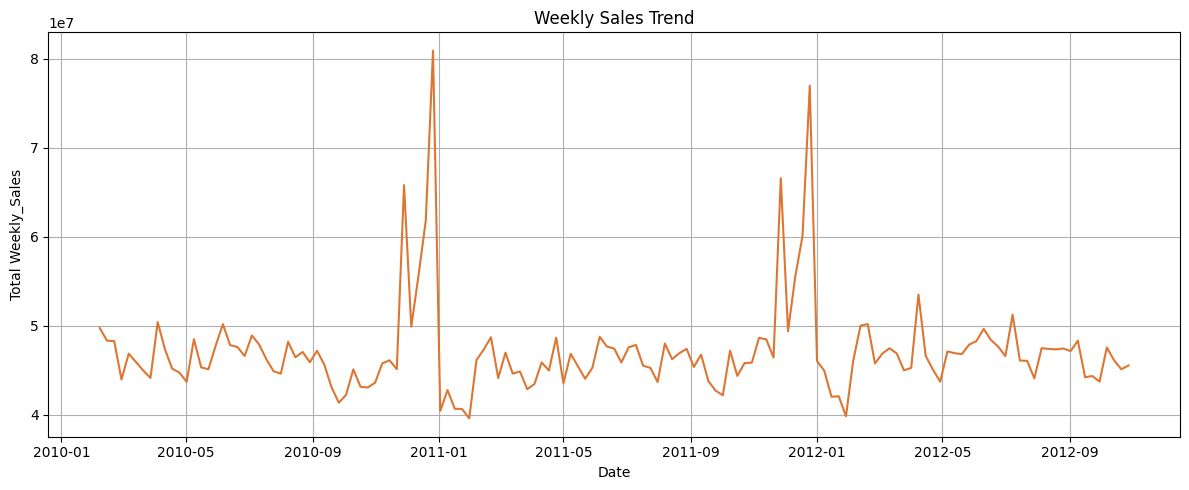

In [198]:
aggregate_and_plot(df, date_col="Date", value_col="Weekly_Sales", freq="W", title="Weekly Sales Trend")

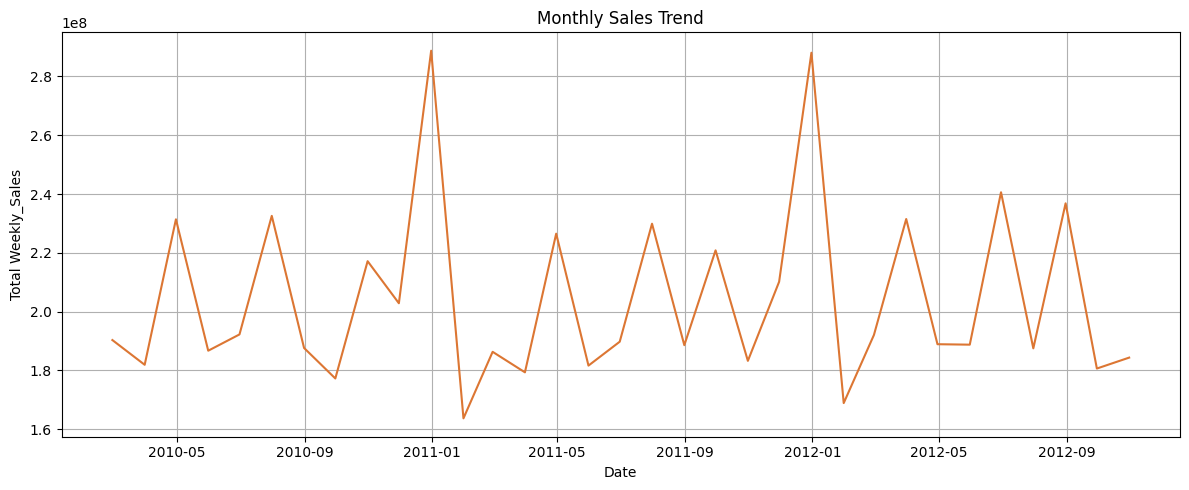

In [199]:
aggregate_and_plot(df, date_col="Date", value_col="Weekly_Sales", freq="M", title="Monthly Sales Trend")

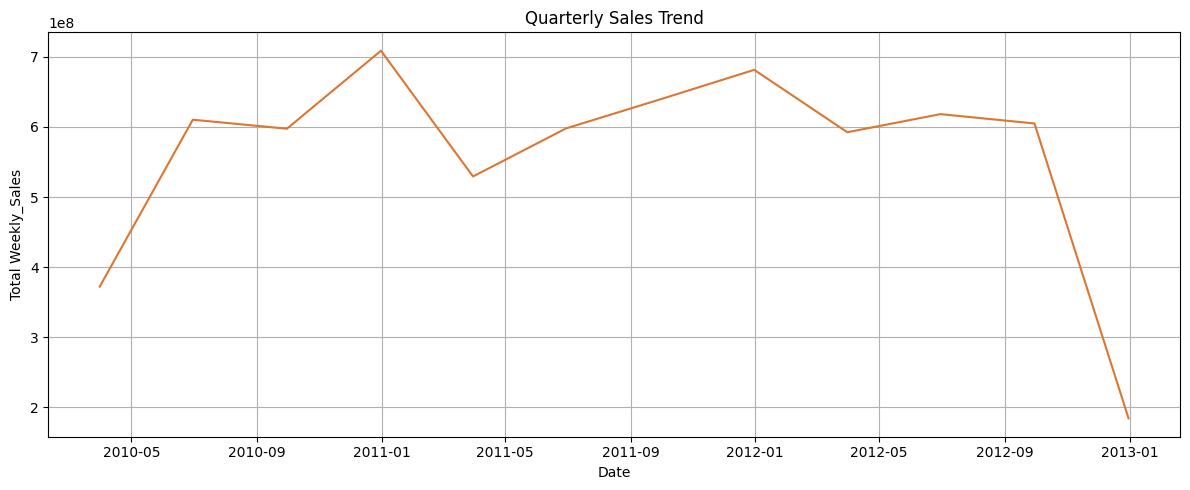

In [200]:
aggregate_and_plot(df, date_col="Date", value_col="Weekly_Sales", freq="Q", title="Quarterly Sales Trend")

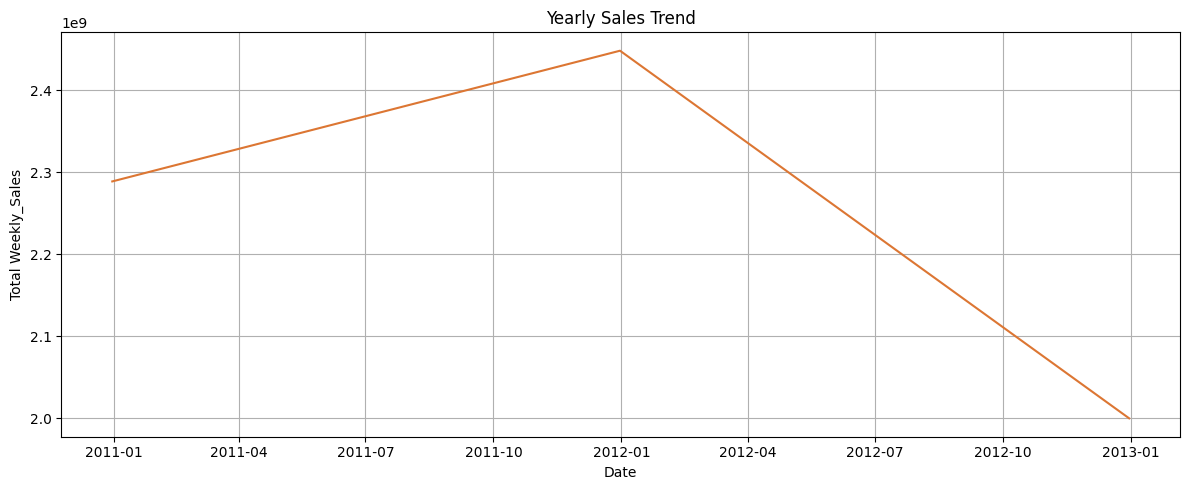

In [201]:
aggregate_and_plot(df, date_col="Date", value_col="Weekly_Sales", freq="Y", title="Yearly Sales Trend")

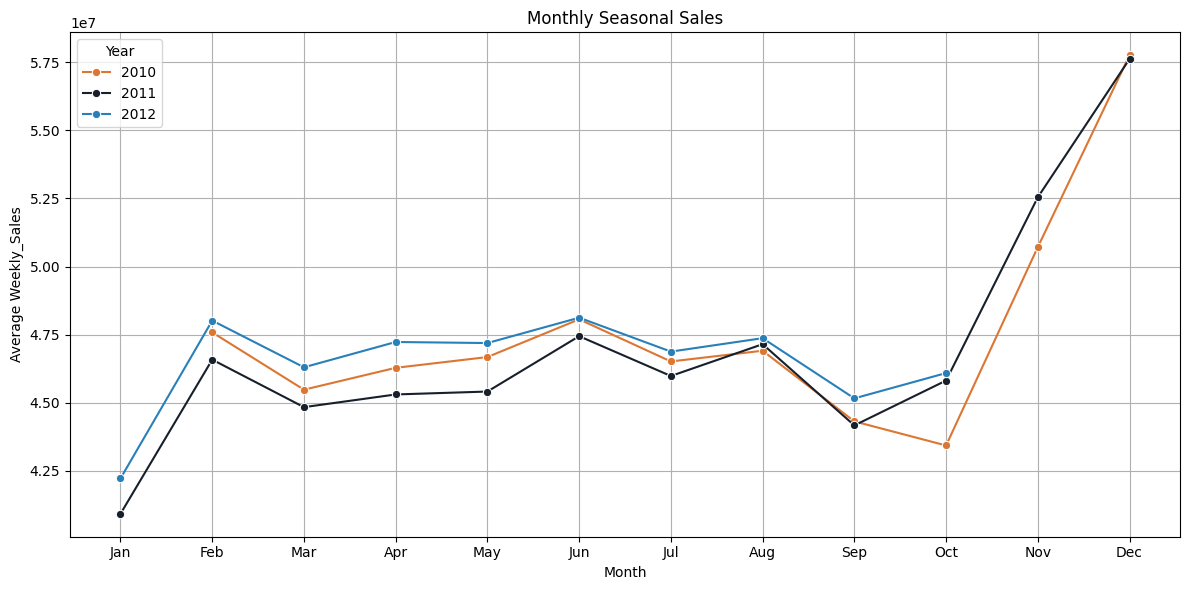

In [202]:
# to see some seasonal patterns
def seasonal_plot(df, date_col, value_col, freq="M", title=None):
    df = df.copy()

    # Convert to datetime and extract year
    df[date_col] = pd.to_datetime(df[date_col])
    df["Year"] = df[date_col].dt.year

    # Extract the appropriate time period based on frequency
    if freq == "M":
        df["Period"] = df[date_col].dt.month
        period_label = "Month"
    elif freq == "Q":
        df["Period"] = df[date_col].dt.quarter
        period_label = "Quarter"
    elif freq == "W":
        df["Period"] = df[date_col].dt.isocalendar().week
        period_label = "Week"
    
    # Calculate seasonal averages by Year and Period
    seasonal_avg = df.groupby(["Year", "Period"])[value_col].mean().reset_index()

    # Define custom colors for each year
    custom_palette = {
        seasonal_avg["Year"].unique()[0]: "#dc7633",  
        seasonal_avg["Year"].unique()[1]: "#17202a",  
        seasonal_avg["Year"].unique()[2]: "#2980b9",  
    }

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=seasonal_avg, x="Period", y=value_col, hue="Year", marker="o", palette=custom_palette)
    
    plt.title(title or f"Seasonal Plot of {value_col} by {period_label}")
    plt.xlabel(period_label)
    plt.ylabel(f"Average {value_col}")
    
    # Set x-ticks for months if monthly frequency
    if freq == "M":
        plt.xticks(ticks=range(1, 13), labels=[
            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
        ])
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()
seasonal_plot(df, date_col="Date", value_col="Weekly_Sales", freq="M", title="Monthly Seasonal Sales")

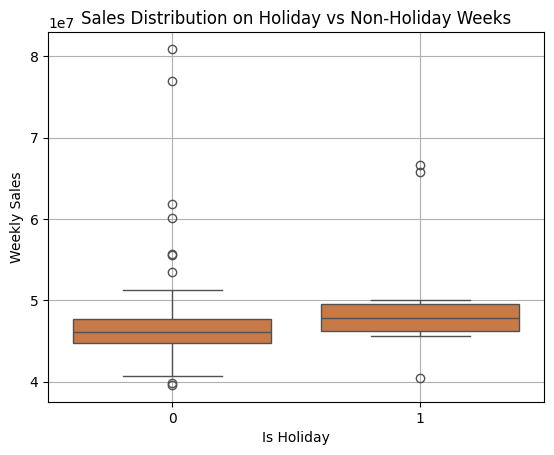

In [203]:
sns.boxplot(x="IsHoliday", y="Weekly_Sales", data=df,color = "#dc7633")
plt.title("Sales Distribution on Holiday vs Non-Holiday Weeks")
plt.xlabel("Is Holiday")
plt.ylabel("Weekly Sales")
plt.grid(True)
plt.show()


## 3. Clean data

### 3.1 deal with missing value

In [204]:
missing_data = df.isnull().sum().to_frame()

# Rename column holding the sums
missing_data = missing_data.rename(columns={0:'Empty Cells'})

# Print the results
print(missing_data)


              Empty Cells
Date                    0
Weekly_Sales            0
Temperature             0
Fuel_Price              0
CPI                     0
Unemployment            0
MarkDown1              92
MarkDown2              95
MarkDown3              92
MarkDown4              92
MarkDown5              92
IsHoliday               0
Year                    0
Month                   0
Day                     0


We can see the empty value are all gathering in Markdowns.

              Empty Cells  Missing Ratio
Date                    0           0.00
Weekly_Sales            0           0.00
Temperature             0           0.00
Fuel_Price              0           0.00
CPI                     0           0.00
Unemployment            0           0.00
MarkDown1              92          64.34
MarkDown2              95          66.43
MarkDown3              92          64.34
MarkDown4              92          64.34
MarkDown5              92          64.34
IsHoliday               0           0.00
Year                    0           0.00
Month                   0           0.00
Day                     0           0.00


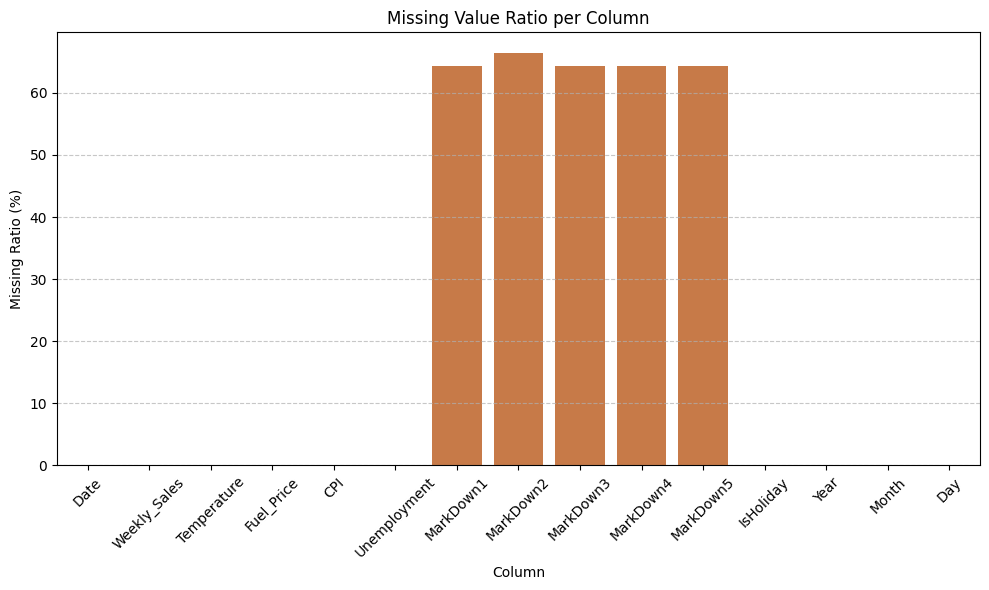

In [205]:
# Calculate number of missing values per column
missing_data = df.isnull().sum().to_frame()

# Rename column holding the sums
missing_data = missing_data.rename(columns={0: 'Empty Cells'})

# Calculate missing ratio (percentage) and add as new column
missing_data['Missing Ratio'] = (missing_data['Empty Cells'] / len(df)) * 100

# Round to 2 decimal places for cleaner display
missing_data['Missing Ratio'] = missing_data['Missing Ratio'].round(2)

# Print the results
print(missing_data)

# Visualize the missing ratios
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.index, y=missing_data['Missing Ratio'], color = "#dc7633")
plt.title("Missing Value Ratio per Column")
plt.ylabel("Missing Ratio (%)")  # Added % to clarify units
plt.xlabel("Column")
plt.xticks(rotation=45)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

A little bit visualization of missing values. These 5 Markdowns account for about 64.34% to 66.43% of all data. We can see how they are distribting in the datasets. 

<Axes: >

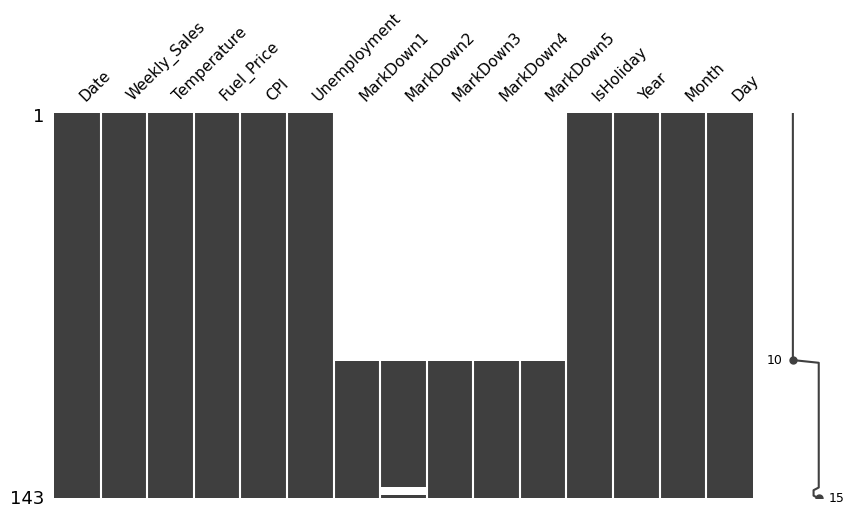

In [206]:
import missingno as msno

# Plot a matrix chart, set chart and font size
msno.matrix(df, figsize=(10,5), fontsize=11)

In [207]:

for col in ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]:
    df[col].fillna(0, inplace=True)

impute_missing_data = df.isnull().sum().to_frame()

# Rename column holding the sums
impute_missing_data = impute_missing_data.rename(columns={0:'Empty Cells'})

# Print the results
print(impute_missing_data)

              Empty Cells
Date                    0
Weekly_Sales            0
Temperature             0
Fuel_Price              0
CPI                     0
Unemployment            0
MarkDown1               0
MarkDown2               0
MarkDown3               0
MarkDown4               0
MarkDown5               0
IsHoliday               0
Year                    0
Month                   0
Day                     0


Missing values in markdown columns are expected - they represent normal non-promotional periods when no discounts were applied. This pattern reflects actual retail operations where markdowns only occur during seasonal sales or clearance events. The empty values should be preserved as meaningful business signals rather than treated as data errors. THerefore, I am going to replace the empty values to 0.

### 3.2 remove outliers

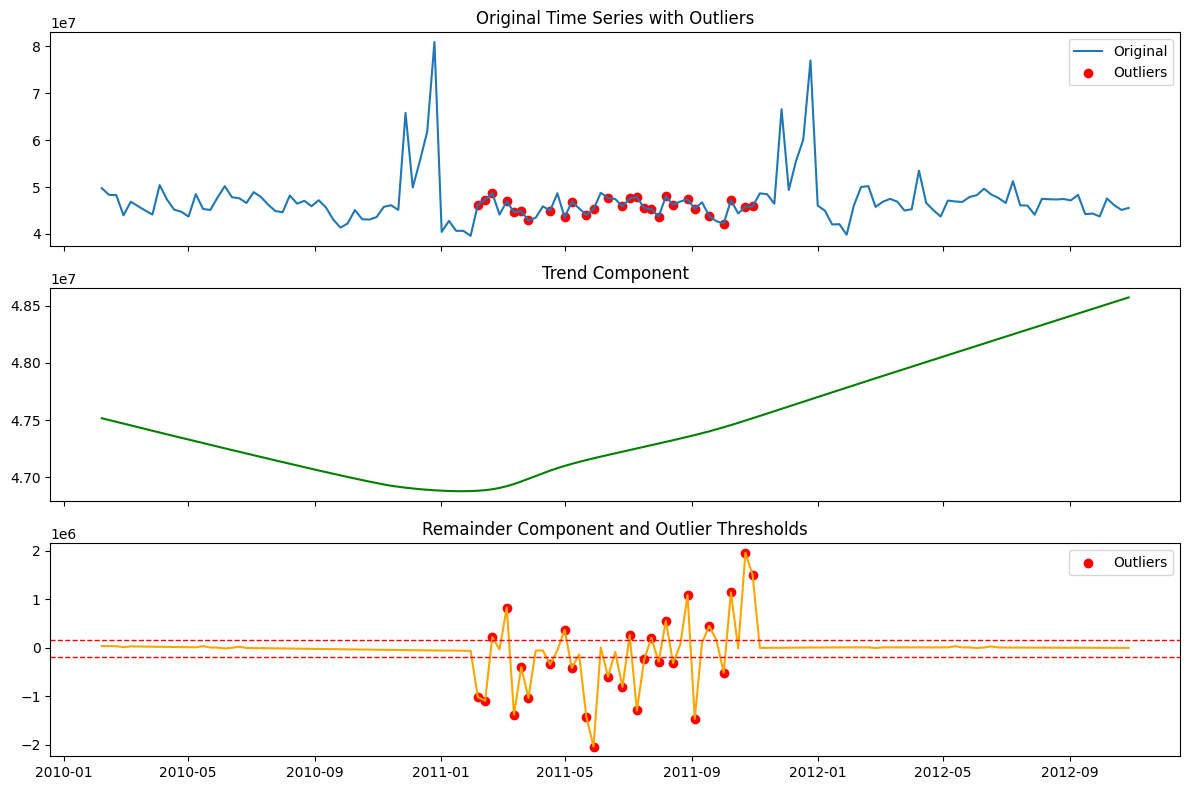

,Weekly_Sales,trend,remainder,is_outlier
Date,,,,
2011-02-06,46153111.12,4.688383e+07,-1.019753e+06,True
2011-02-13,47336192.79,4.688890e+07,-1.095379e+06,True
2011-02-20,48716164.12,4.689682e+07,2.139854e+05,True
2011-03-06,46980603.74,4.692353e+07,8.253194e+05,True
2011-03-13,44627319.40,4.694255e+07,-1.382115e+06,True
2011-03-20,44872325.97,4.696456e+07,-3.998168e+05,True
2011-03-27,42876199.18,4.698844e+07,-1.036741e+06,True
2011-04-17,44973328.14,4.705958e+07,-3.476819e+05,True
2011-05-01,43530032.78,4.710040e+07,3.679354e+05,True


In [208]:
def detect_outliers_stl(df, date_col="Date", value_col="Weekly_Sales", freq="W", iqr_multiplier=3):
   
    # Copy the original dataframe and parse datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    ts = df[[date_col, value_col]].dropna()

    # Resample to defined frequency and aggregate (e.g., weekly sales sum)
    ts = ts.set_index(date_col).resample(freq).sum()

    # Apply STL decomposition: seasonality disabled (period=1), robust to outliers
    stl = STL(ts[value_col], seasonal=53, robust=True)
    result = stl.fit()
    ts["trend"] = result.trend
    ts["remainder"] = result.resid

    # Outlier detection using IQR method
    Q1 = ts["remainder"].quantile(0.25)
    Q3 = ts["remainder"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - iqr_multiplier * IQR
    upper = Q3 + iqr_multiplier * IQR
    ts["is_outlier"] = (ts["remainder"] < lower) | (ts["remainder"] > upper)

    # Plot: original + outliers, trend, remainder with thresholds
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    axs[0].plot(ts.index, ts[value_col], label="Original")
    axs[0].scatter(ts.index[ts["is_outlier"]], ts[value_col][ts["is_outlier"]],
                   color="red", label="Outliers")
    axs[0].set_title("Original Time Series with Outliers")
    axs[0].legend()

    axs[1].plot(ts.index, ts["trend"], color="green")
    axs[1].set_title("Trend Component")

    axs[2].plot(ts.index, ts["remainder"], color="orange")
    axs[2].axhline(upper, color="red", linestyle="--", linewidth=1)
    axs[2].axhline(lower, color="red", linestyle="--", linewidth=1)
    axs[2].scatter(ts.index[ts["is_outlier"]], ts["remainder"][ts["is_outlier"]],
                   color="red", label="Outliers")
    axs[2].set_title("Remainder Component and Outlier Thresholds")
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    return ts
ts_outliers = detect_outliers_stl(df, date_col="Date", value_col="Weekly_Sales", iqr_multiplier=3)

ts_outliers[ts_outliers["is_outlier"] == True]





In [209]:
# Step 1: Identify IQR outliers
Q1 = df["Weekly_Sales"].quantile(0.25)
Q3 = df["Weekly_Sales"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df["Weekly_Sales"] < lower) | (df["Weekly_Sales"] > upper)]

# Step 2: Further filter out rows where all markdowns are zero
true_outliers = outliers[
    (df["MarkDown1"] == 0) &
    (df["MarkDown2"] == 0) &
    (df["MarkDown3"] == 0) &
    (df["MarkDown4"] == 0) &
    (df["MarkDown5"] == 0)
]



In [210]:
df_cleaned = df.drop(true_outliers.index)

In [211]:
print(f"Original dataset: {df.shape[0]} rows")
print(f"Cleaned dataset: {df_cleaned.shape[0]} rows")
print(f"Removed outliers: {df.shape[0] - df_cleaned.shape[0]} rows")


Original dataset: 143 rows
Cleaned dataset: 137 rows
Removed outliers: 6 rows


I carefully considered that high sales values might be legitimate results of discount activities rather than true anomalies. To distinguish between actual outliers and promotion-driven sales spikes, I first identified potential outliers using the IQR method (Q1-1.5IQR to Q3+1.5IQR). Then, I cross-verified these cases by checking whether any markdown values were greater than 0, indicating active promotions. This approach ensured I only removed true anomalies (6 records) while preserving valid promotional sales patterns. 

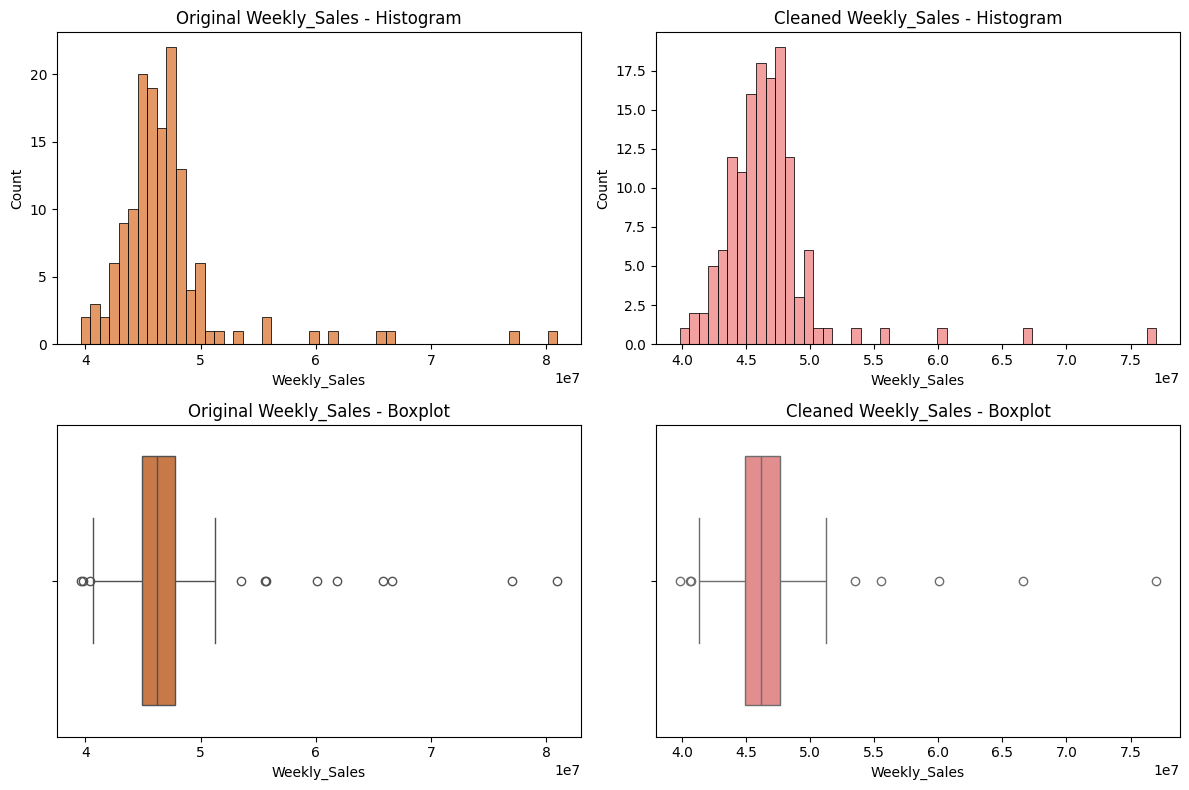

In [212]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# original hist
sns.histplot(df["Weekly_Sales"], bins=50, ax=axs[0, 0], color='#dc7633')
axs[0, 0].set_title("Original Weekly_Sales - Histogram")

# cleaned hist
sns.histplot(df_cleaned["Weekly_Sales"], bins=50, ax=axs[0, 1], color='lightcoral')
axs[0, 1].set_title("Cleaned Weekly_Sales - Histogram")

# original box plot
sns.boxplot(x=df["Weekly_Sales"], ax=axs[1, 0], color='#dc7633')
axs[1, 0].set_title("Original Weekly_Sales - Boxplot")

# cleaned box plot
sns.boxplot(x=df_cleaned["Weekly_Sales"], ax=axs[1, 1], color='lightcoral')
axs[1, 1].set_title("Cleaned Weekly_Sales - Boxplot")

plt.tight_layout()
plt.show()

### normalizing data

In [213]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the original dataframe to preserve raw data
df_scaled = df_cleaned.copy()

# Define the columns to standardize
columns_to_standardize = [
    "Temperature", "Fuel_Price", "CPI", "Unemployment",
    "Weekly_Sales", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"
]

# Fill missing values first (required for standardization)
df_scaled[columns_to_standardize] = df_scaled[columns_to_standardize].fillna(0)

# Initialize the scaler
scaler = StandardScaler()

# Apply standardization (Z-score normalization)
df_scaled[columns_to_standardize] = scaler.fit_transform(df_scaled[columns_to_standardize])

# Preview the result
df_scaled.head()


,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,Year,Month,Day
0,2010-02-05,0.753893,-1.873378,-1.522024,-1.276472,1.349298,-0.535865,-0.215286,-0.097852,-0.364215,-0.633792,0,2010,2,5
1,2010-02-12,0.408546,-1.867722,-1.572494,-1.281119,1.329228,-0.535865,-0.215286,-0.097852,-0.364215,-0.633792,1,2010,2,12
2,2010-02-19,0.393969,-1.619811,-1.624515,-1.295834,1.348489,-0.535865,-0.215286,-0.097852,-0.364215,-0.633792,0,2010,2,19
3,2010-02-26,-0.658249,-1.512511,-1.596748,-1.181152,1.316586,-0.535865,-0.215286,-0.097852,-0.364215,-0.633792,0,2010,2,26
4,2010-03-05,0.050707,-1.260019,-1.489686,-1.169317,1.340687,-0.535865,-0.215286,-0.097852,-0.364215,-0.633792,0,2010,3,5


Normalizing data ensures that features with larger scales don't dominate the model training process. In this dataset, normalization helps models like linear regression or neural networks treat all features fairly, improving convergence speed and prediction accuracy.


### 3.3 undersampling/oversampling

As this is a regression problem, there is no label exist which means undersampling/oversampling will not be considered as a proper option.

### 3.4 Feature selection

In [214]:


X = df_scaled.drop(columns=['Weekly_Sales', 'Date'])
y = df_scaled['Weekly_Sales']
# Lasso is sensitive to feature scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Fit Lasso model with cross-validation
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_scaled, y)

# Step 4: Extract selected features (non-zero coefficients)
coef = pd.Series(lasso.coef_, index=X.columns)
selected_features = coef[coef != 0]

# Step 5: Display selected features
print("Selected features by Lasso:")
print(selected_features)


Selected features by Lasso:
MarkDown3    0.106347
dtype: float64


In [215]:
import pandas as pd
import statsmodels.api as sm

# Step 1: Prepare features and target
X = df_scaled.drop(columns=['Weekly_Sales', 'Date'])  # Remove target and Date
y = df_scaled['Weekly_Sales']

# Step 2: Add constant term for intercept
X = sm.add_constant(X)

# Step 3: Backward Elimination loop
def backward_selection(X, y, significance_level=0.05):
    X_selected = X.copy()
    while True:
        model = sm.OLS(y, X_selected).fit()
        p_values = model.pvalues
        max_p = p_values.max()
        if max_p > significance_level:
            excluded_feature = p_values.idxmax()
            print(f"Dropping '{excluded_feature}' (p={max_p:.4f})")
            X_selected = X_selected.drop(columns=[excluded_feature])
        else:
            break
    return X_selected.columns.tolist(), model

# Step 4: Run backward selection
selected_columns, final_model = backward_selection(X, y)

# Step 5: Display selected features
print("\n Selected features by Backward Selection:")
print(selected_columns)


Dropping 'MarkDown1' (p=0.9674)
Dropping 'MarkDown4' (p=0.8298)
Dropping 'IsHoliday' (p=0.5416)
Dropping 'MarkDown5' (p=0.4535)
Dropping 'Month' (p=0.4031)
Dropping 'Temperature' (p=0.1263)
Dropping 'MarkDown2' (p=0.1264)
Dropping 'Fuel_Price' (p=0.0623)
Dropping 'Unemployment' (p=0.1716)

 Selected features by Backward Selection:
['const', 'CPI', 'MarkDown3', 'Year', 'Day']


Lasso is used in this case because it performs both variable selection and regularization, which helps reduce overfitting and improve model interpretability. Since the dataset includes many potentially correlated features, Lasso helps automatically eliminate irrelevant ones by shrinking their coefficients to zero.
Using Lasso regression with cross-validation, seven features were selected, including temperature, multiple markdowns, and month. These variables show the strongest relationship with weekly sales and will be used for further modeling.


Backward selection is used in this case to iteratively remove features with the highest p-values, keeping only those that are statistically significant. This improves model simplicity and avoids including irrelevant predictors. The final selected variables are CPI, MarkDown3, Year, and Day, which showed strong statistical relationships with weekly sales. The feature const is automatically added as the intercept term in the regression model and is necessary to estimate the baseline sales level when all predictors are zero.

## 4. Identify correlated variables

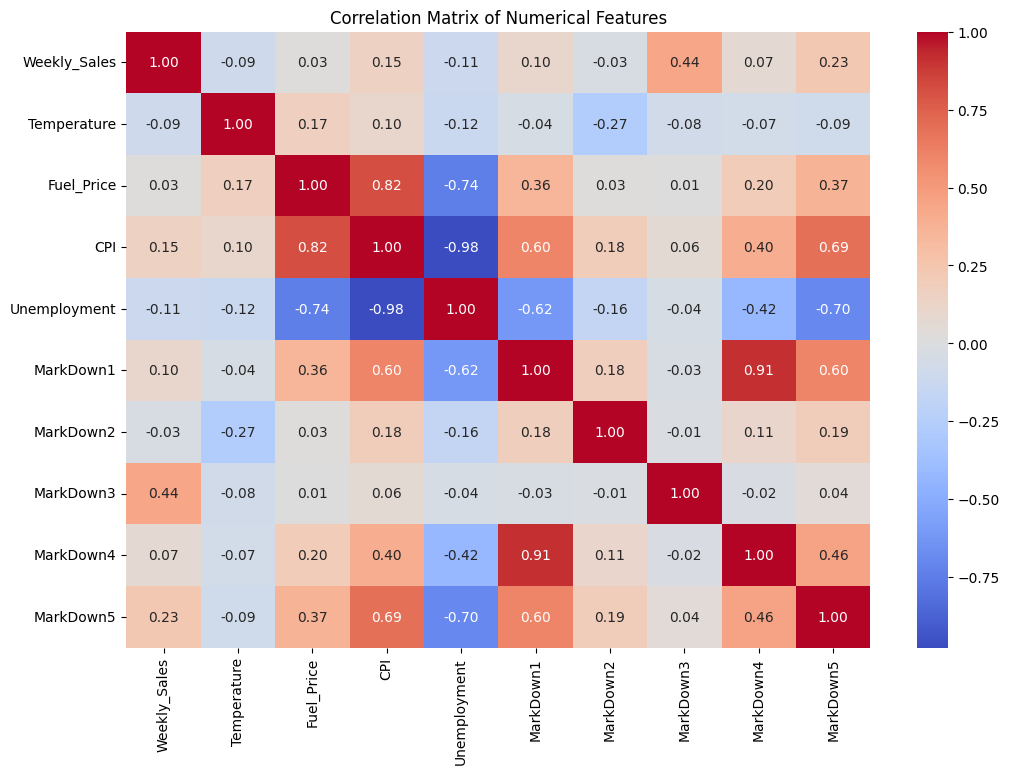

In [216]:
numeric_df = df_scaled.select_dtypes(include=["float64", "int64"])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

The heatmap reveals strong correlations between CPI and Fuel_Price (0.82), and between MarkDown4 and MarkDown1 (0.91), indicating multicollinearity. To reduce redundancy, one feature from each pair should be removed. Notably, in the backward selection results, none of these highly correlated variables were retained—only CPI and MarkDown3 were selected—suggesting the method effectively filtered out multicollinear features and preserved only those with independent predictive power.